In [ ]:
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from typing import List

In [ ]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20221020'
}

In [ ]:
q = """
select count(distinct user_id)
from {db}.feed_actions 
where toDate(time) >= '2022-09-26' and toDate(time) <= '2022-10-02' 
"""

In [ ]:
# юзера для A/A теста
ph.read_clickhouse(q, connection=connection)

,uniqExact(user_id)
0,42585


In [ ]:
q = """
select user_id,
exp_group, 
countIf(action='like') as likes,
countIf(action='view') as views, 
likes / views as ctr
from {db}.feed_actions
where toDate(time) >= '2022-09-26' and toDate(time) <= '2022-10-02'
and exp_group in (2, 3)
group by exp_group, user_id

"""

In [ ]:
df_aa = ph.read_clickhouse(q, connection=connection)

In [ ]:
# датафрейм для A/A теста с ctr для каждого юзера
df_aa

,user_id,exp_group,likes,views,ctr
0,115383,3,11,36,0.305556
1,123580,3,15,92,0.163043
2,131473,2,26,148,0.175676
3,23985,2,12,66,0.181818
4,24523,2,17,120,0.141667
...,...,...,...,...,...
17044,122008,3,4,31,0.129032
17045,25383,2,16,57,0.280702
17046,122190,3,25,74,0.337838
17047,108927,2,8,33,0.242424


In [ ]:
# проверяем, имеют ли группы однаковый размер 
df_aa.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


In [ ]:
sns.set(rc={'figure.figsize':(10, 10)})

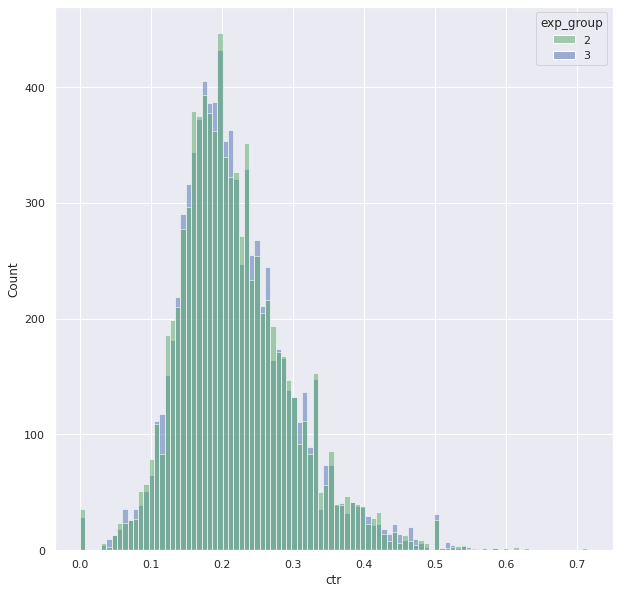

In [ ]:
groups = sns.histplot(data=df_aa,
                      x='ctr',
                      hue='exp_group',
                      palette=['g', 'b'],
                      kde=False,
                      alpha=0.5)

Экспериментальные группы имеют одинаковые распределения

In [ ]:
def bootstrap_aa(n_bootstrap: int = 10_000, 
                 B: int = 500,
) -> List:
    pvalues = []
    for _ in range(n_bootstrap):
        group_2 = df_aa[df_aa['exp_group'] == 2]['ctr'].sample(B, replace=False).tolist()
        group_3 = df_aa[df_aa['exp_group'] == 3]['ctr'].sample(B, replace=False).tolist()
        pvalues.append(st.ttest_ind(group_2, group_3, equal_var=False)[1])
    
    return pvalues

In [ ]:
pvalues = bootstrap_aa()

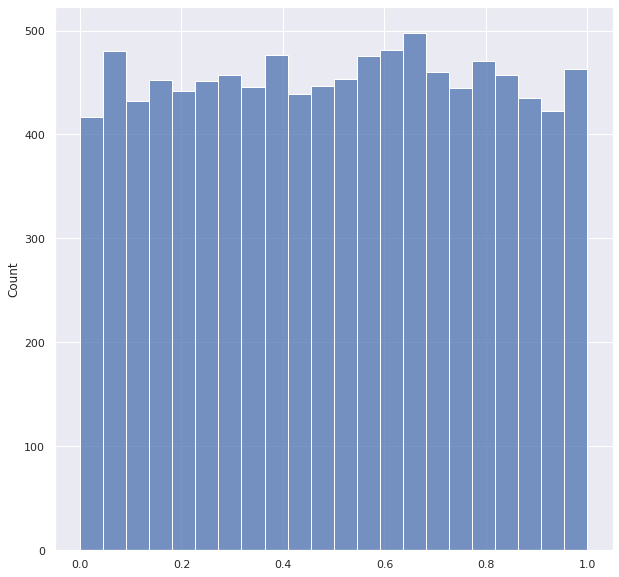

In [ ]:
sns.histplot(pvalues)

In [ ]:
perc = sum([1 for i in pvalues if i <= 0.05]) / 10000 * 100
print(f'{perc}% is the percent of p-values which are less than 0.05 ')

4.63% is the percent of p-values which are less than 0.05 


**Вывод:** 
Поскольку только в ~5% случаях мы получаем стат. значимые различия, что соответствует ошибке I рода. Следовательно, можно заключить, что система сплитования на группы работает корректно